In [3]:
# Uber Fare Prediction (Regression) — Using Euclidean Distance
# Models: Linear Regression and Random Forest Regression
# Tasks: Data cleaning, outlier handling, correlation, evaluation, and visualizations

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

sns.set(style="whitegrid")

In [4]:
# Step 1: Load dataset
df = pd.read_csv("uber.csv")  # ensure uber.csv is in the same folder

In [5]:
# Step 2: Remove unnecessary or empty columns
df = df.drop(columns=['Unnamed: 0', 'key'], errors='ignore')
df = df.dropna(subset=['pickup_latitude', 'pickup_longitude',
                       'dropoff_latitude', 'dropoff_longitude',
                       'fare_amount', 'passenger_count'])

# Keep only valid, logical values
df = df[(df['fare_amount'] > 0) & (df['passenger_count'] > 0)]
df = df[(df['pickup_latitude'].between(-90, 90)) & (df['dropoff_latitude'].between(-90, 90))]
df = df[(df['pickup_longitude'].between(-180, 180)) & (df['dropoff_longitude'].between(-180, 180))]

In [6]:
# Step 3: Create distance feature (Euclidean distance)
# 1 degree latitude ≈ 111 km (approx conversion factor)
df['distance_km'] = np.sqrt(
    (df['dropoff_latitude'] - df['pickup_latitude'])**2 +
    (df['dropoff_longitude'] - df['pickup_longitude'])**2
) * 111

In [7]:
# Step 4: Extract hour and weekday from pickup_datetime
if 'pickup_datetime' in df.columns:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
    df['hour'] = df['pickup_datetime'].dt.hour
    df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
else:
    df['hour'] = 0
    df['dayofweek'] = 0

In [8]:
# Step 5: Remove outliers using quantile limits
df = df[df['distance_km'] < df['distance_km'].quantile(0.99)]
df = df[df['fare_amount'] < df['fare_amount'].quantile(0.99)]
df = df[df['distance_km'] > 0.01]  # remove zero-distance rides

print("Data ready after cleaning:", df.shape)

Data ready after cleaning: (189280, 10)


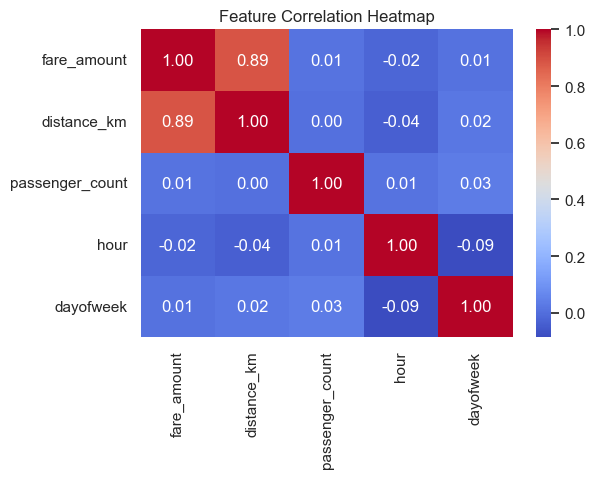

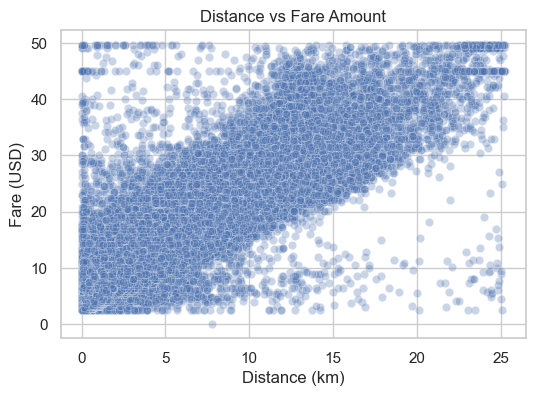

In [9]:
# Step 6: Correlation check
corr = df[['fare_amount', 'distance_km', 'passenger_count', 'hour', 'dayofweek']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Scatter plot between distance and fare
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='distance_km', y='fare_amount', alpha=0.3)
plt.title("Distance vs Fare Amount")
plt.xlabel("Distance (km)")
plt.ylabel("Fare (USD)")
plt.show()

In [10]:
# Step 7: Split data into train/test sets
X = df[['distance_km', 'passenger_count', 'hour', 'dayofweek']]
y = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Step 8: Build and train models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42, n_estimators=100)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [12]:
# Step 9: Predictions
pred_lr = lr.predict(X_test)
pred_rf = rf.predict(X_test)

In [13]:
# Step 10: Evaluate models
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} → R² = {r2:.3f}, RMSE = {rmse:.2f}")

print("\nModel Performance:")
evaluate_model("Linear Regression", y_test, pred_lr)
evaluate_model("Random Forest", y_test, pred_rf)


Model Performance:
Linear Regression → R² = 0.788, RMSE = 3.31
Random Forest → R² = 0.775, RMSE = 3.41


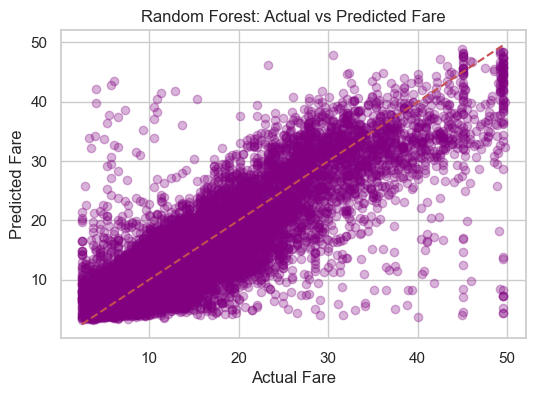

In [14]:
# Step 11: Visualization — Actual vs Predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, pred_rf, color='purple', alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Random Forest: Actual vs Predicted Fare")
plt.show()

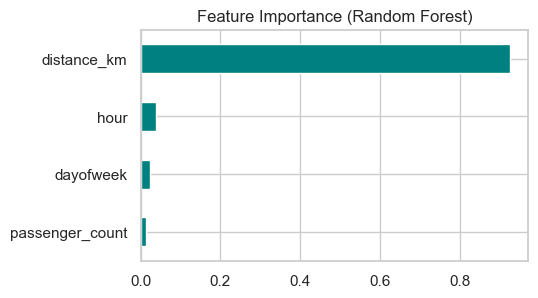

In [15]:
# Step 12: Feature Importance (Random Forest)
feat_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(5, 3))
feat_importance.plot(kind='barh', color='teal')
plt.title("Feature Importance (Random Forest)")
plt.show()